# Model initialization and selection procedure

In this notebook, we will show how CoPro is initialized and how the polygons and conflicts are selected.

## Model initialization

Start with loading the required packages.

In [1]:
from copro import utils, selection, plots, data

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os, sys
import warnings
warnings.simplefilter("ignore")

For better reproducibility, the version numbers of all key packages are provided.

In [2]:
utils.show_versions()

Python version: 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 01:53:57) [MSC v.1916 64 bit (AMD64)]
copro version: 0.0.8b
geopandas version: 0.8.0
xarray version: 0.15.1
rasterio version: 1.1.0
pandas version: 1.0.3
numpy version: 1.18.1
scikit-learn version: 0.23.2
matplotlib version: 3.2.1
seaborn version: 0.11.0
rasterstats version: 0.14.0


### The configurations-file (cfg-file)

In the cfg-file, all the settings for the analysis are defined. Note that the cfg-file can be stored anywhere, not per se in the same directory where the model data is stored (as in this example case). Make sure that the paths in the cfg-file are updated if you use relative paths and change the folder location of th cfg-file.

In [3]:
settings_file = 'example_settings.cfg'

Based on this cfg-file, the set-up of the run can be initialized. Here, the cfg-file is parsed (i.e. read) and all settings and paths become known to the model. Also, the output folder is created (if it does not exist yet) and the cfg-file is copied to the output folder for improved reusability.

In [4]:
main_dict, root_dir = utils.initiate_setup(settings_file)


#### CoPro version 0.0.8b ####
#### For information about the model, please visit https://copro.readthedocs.io/ ####
#### Copyright (2020-2021): Jannis M. Hoch, Sophie de Bruin, Niko Wanders ####
#### Contact via: j.m.hoch@uu.nl ####
#### The model can be used and shared under the MIT license ####

INFO: parsing configurations for file example_settings.cfg
INFO: parsing configurations for file C:\Users\hoch0001\Documents\_code\copro\example\example_settings_proj.cfg
INFO: parsing configurations for file C:\Users\hoch0001\Documents\_code\copro\example\example_settings_proj.cfg
INFO: verbose mode on: True
INFO: saving output to main folder C:\Users\hoch0001\Documents\_code\copro\example\./OUT
DEBUG: remove files in C:\Users\hoch0001\Documents\_code\copro\example\OUT\_REF
DEBUG: sparing XY.npy
DEBUG: remove files in C:\Users\hoch0001\Documents\_code\copro\example\OUT\_REF\files
DEBUG: remove files in C:\Users\hoch0001\Documents\_code\copro\example\OUT\_PROJ\test1
DEBUG: sparing X.npy
DEB

One of the outputs is a dictionary containing the parsed configurations as well as output directories of both the reference run and the various projection runs:

In [5]:
main_dict

{'_REF': [<configparser.RawConfigParser at 0x265aab541c8>,
  'C:\\Users\\hoch0001\\Documents\\_code\\copro\\example\\./OUT\\_REF'],
 'test1': [[<configparser.RawConfigParser at 0x265aaa72b88>],
  'C:\\Users\\hoch0001\\Documents\\_code\\copro\\example\\./OUT\\_PROJ\\test1'],
 'testZWEI': [[<configparser.RawConfigParser at 0x265b0f84808>],
  'C:\\Users\\hoch0001\\Documents\\_code\\copro\\example\\./OUT\\_PROJ\\testZWEI']}

For the reference run, only the respective entries are required.

In [6]:
config_REF = main_dict['_REF'][0]
out_dir_REF = main_dict['_REF'][1] 

## Filter conflicts and polygons

### Background

As conflict database, we use the [UCDP Georeferenced Event Dataset](https://ucdp.uu.se/downloads/index.html#ged_global) v201. Not all conflicts of the database may always need to be used for a simulation. This can be, for example, because they belong to a non-relevant type of conflict we are not interested in, or because it is simply not in our area-of-interest. Therefore, it is possible to filter the conflicts on various properties:

1. min_nr_casualties: minimum number of casualties of a reported conflict; 
1. type_of_violence: 1=state-based armed conflict; 2=non-state conflict; 3=one-sided violence.

To unravel the interplay between climate and conflict, it may be beneficial to run the model only for conflicts in particular climate zones. It is hence also possible to select only those conflcits that fall within a climate zone following the [Koeppen-Geiger classification](http://koeppen-geiger.vu-wien.ac.at/).

### Selection procedure

In the selection procedure, we first load the conflict database and convert it to a georeferenced dataframe (geo-dataframe). To define the study area, a shape-file containing polygons (in this case water provinces) is loaded and converted to geo-dataframe as well.

We then apply the selection criteria (see above) as specified in the cfg-file, and keep the remaining data points and polygons. 

In [7]:
conflict_gdf, extent_gdf, selected_polygons_gdf, global_df = selection.select(config_REF, out_dir_REF, root_dir)

INFO: reading csv file to dataframe C:\Users\hoch0001\Documents\_code\copro\example\./example_data\UCDP/ged201.csv
DEBUG: translating to geopandas dataframe
INFO: filtering on conflict properties.
DEBUG: filtering key best with lower value 1
DEBUG: filtering key type_of_violence with value(s) ['1', '2', '3']
DEBUG: focussing on period between 1995 and 2012
INFO: reading extent and spatial aggregation level from file C:\Users\hoch0001\Documents\_code\copro\example\./example_data\waterProvinces/waterProvinces_Africa.shp
INFO: fixing invalid geometries
INFO: clipping clipping conflict dataset to extent
DEBUG: clipping conflicts to climate zones ['BWh', 'BSh']
DEBUG: clipping polygons to climate zones ['BWh', 'BSh']


With the chosen settings, the following picture of polygons and conflict data points is obtained.

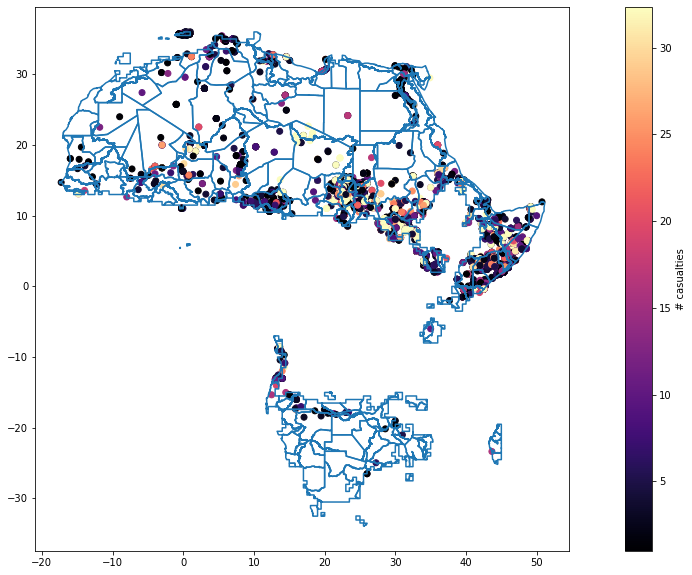

In [8]:
fig, ax= plt.subplots(1, 1, figsize=(20,10))
conflict_gdf.plot(ax=ax, c='r', column='best', cmap='magma', 
                  vmin=int(config_REF.get('conflict', 'min_nr_casualties')), vmax=conflict_gdf.best.mean(), 
                  legend=True, 
                  legend_kwds={'label': "# casualties", 'orientation': "vertical", 'pad': 0.05})
selected_polygons_gdf.boundary.plot(ax=ax);

To be able to also run the following notebooks, some of the data has to be written to file temporarily.

In [9]:
if not os.path.isdir('temp_files'):
        os.makedirs('temp_files')

In [10]:
conflict_gdf.to_file(os.path.join('temp_files', 'conflicts.shp'))
selected_polygons_gdf.to_file(os.path.join('temp_files', 'polygons.shp'))

In [11]:
global_df['ID'] = global_df.index.values
global_arr = global_df.to_numpy()
np.save(os.path.join('temp_files', 'global_df'), global_arr)